In [12]:
%load_ext sql
%sql sqlite:///base.db
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Написание функций для работы с sqlite с использованием python

Зачем нужно:

- Анализ данных и другие сложные операции
- API (application programming interface)

In [2]:
%%sql
Pragma foreign_keys=on;

DROP TABLE if exists Products;
DROP TABLE if exists Invoices;
DROP TABLE if exists Customers;

CREATE TABLE Customers (
          cust_ID integer NOT NULL Primary key,
          cust_name varchar NOT NULL UNIQUE,
          cust_password varchar NOT NULL,
          address varchar NOT NULL
          );

CREATE TABLE Invoices (
          invoice_ID integer NOT NULL Primary key,
          product_id integer NOT NULL,
          customer_id integer NOT NULL,
          qty integer DEFAULT 0,
          order_sum integer DEFAULT 0,
          invoice_date integer,
          FOREIGN KEY (product_id) REFERENCES Products(product_id)
          FOREIGN KEY (customer_id) REFERENCES Customers(cust_ID));

CREATE TABLE Products (
          product_id integer NOT NULL Primary key,
          product_name varchar NOT NULL UNIQUE,
          qty integer NOT NULL DEFAULT 0,
          price integer);

 * sqlite:///base.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [3]:
%%sql

INSERT INTO Products (product_name, qty, price) VALUES ("Ноутбук", 10, 30000);
INSERT INTO Products (product_name, qty, price) VALUES ("Монитор", 20, 10000);
INSERT INTO Products (product_name, qty, price) VALUES ("Наушники", 20, 8000);
INSERT INTO Products (product_name, qty, price) VALUES ("Смартфон", 50, 34000);

 * sqlite:///base.db
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


[]

Необходимо подключить приложение к базе данных:

In [4]:
import sqlite3
connection = sqlite3.connect('base.db') # логин-пароль не нужны, sqlite не работает как отдельный сервер

В случае серверной SQL (на примере MySQL):

connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password
        )

In [5]:
type(connection)

sqlite3.Connection

In [6]:
cur = connection.cursor()

Курсор служит указателем, который позволяет языку программирования обрабатывать результаты запроса по одной записи за раз.

In [7]:
cur.execute("""SELECT *
            FROM Products""") # execute(sql[, parameters]) - создание промежуточного объекта типа cursor и вызов метода execute объекта cursor

In [8]:
a = cur.fetchone() # вывод 1 строки

In [9]:
a

(1, 'Ноутбук', 10, 30000)

In [10]:
cur.fetchall() # вывод всего

[(2, 'Монитор', 20, 10000),
 (3, 'Наушники', 20, 8000),
 (4, 'Смартфон', 50, 34000)]

In [13]:
%sql SELECT * FROM Products;

 * sqlite:///base.db
Done.


product_id,product_name,qty,price
1,Ноутбук,10,30000
2,Монитор,20,10000
3,Наушники,20,8000
4,Смартфон,50,34000


Написать функцию для добавления клиента (имя, инфо):

In [14]:
def insert_customer(name, passw, address, con):
    cur = con.cursor()
    cur.execute('''
        INSERT INTO Customers(cust_name, cust_password, address)
        VALUES(?,?,?)''', (name,passw,address))
    con.commit() # сохранить изменения

In [15]:
insert_customer('Александр', '12345', 'Адрес_1', connection)
insert_customer('Антон', '67890', 'Адрес2', connection)
insert_customer('Михаил', 'qwerty', 'Адрес3', connection)
insert_customer('Наталья', 'asdfgh', 'Адрес4', connection)

In [16]:
%%sql
select * from customers;

 * sqlite:///base.db
Done.


cust_ID,cust_name,cust_password,address
1,Александр,12345,Адрес_1
2,Антон,67890,Адрес2
3,Михаил,qwerty,Адрес3
4,Наталья,asdfgh,Адрес4


Написать функцию для смены адреса клиента

In [17]:
def update_address(name, new_address):
    cur = connection.cursor()
    cur.execute('''UPDATE customers set address = ? where cust_name = ?''', (new_address, name))
    connection.commit()

In [18]:
update_address('Александр', "Новый_адрес");

In [19]:
%%sql
select * from customers;

 * sqlite:///base.db
Done.


cust_ID,cust_name,cust_password,address
1,Александр,12345,Новый_адрес
2,Антон,67890,Адрес2
3,Михаил,qwerty,Адрес3
4,Наталья,asdfgh,Адрес4


Применение пароля для смены адреса:

In [20]:
def update_address(name, passw, new_address):
    cur = connection.cursor()
    cur.execute('''UPDATE customers set address = ? where cust_name = ? and cust_password = ?''', (new_address, name, passw))
    connection.commit()

In [21]:
update_address("Александр", "qwerty", "Адрес_еще_новее");

In [22]:
%%sql
select * from customers;

 * sqlite:///base.db
Done.


cust_ID,cust_name,cust_password,address
1,Александр,12345,Новый_адрес
2,Антон,67890,Адрес2
3,Михаил,qwerty,Адрес3
4,Наталья,asdfgh,Адрес4


Написать функцию для добавления заказа (тоже по паролю).


Вход: имя/пароль клиента, продукт, кол-во

1 шаг - проверка, что такие продукты и клиенты существуют,
2 шаг - добавление в таблицу invoices

In [23]:
def check_client(name, passw): # Проверяем, есть ли такая комбинация имя-пароль
    cur = connection.cursor()
    cur.execute('''select cust_id from customers where cust_name = ? and cust_password = ?''', (name, passw))
    try:
        cli_id = cur.fetchone()[0]
        print('Клиент найден')
        return cli_id
    except:
        print('Ошибка аутентификации')
        return 0

In [24]:
def check_product(product, quantity): # Проверяем, есть ли такой продукт (и кол-во)
    cur = connection.cursor()
    cur.execute('''select qty from products where product_name = ? ''', (product, ))
    try:
        qty = cur.fetchone()[0]
        if quantity > qty:
            print('Нет столько товаров на складе')
            return 0
        cur.execute('''select product_id from products where product_name = ? ''', (product, ))
        product_id = cur.fetchone()[0]
    except:
        print('Такой продукт не существует')
        return 0
    print('Продукт можно забрать')
    return product_id

In [25]:
def add_invoice(customer_id, product, qty, invoice_date):
    cur = connection.cursor()
    cur.execute('''select coalesce(max(invoice_id) + 1, 1) from invoices''')
    inv_id = cur.fetchone()[0]
    cur.execute('''insert into invoices(invoice_id, customer_id, product_id, qty, order_sum, invoice_date)
                    VALUES(?,?,?,?,NULL,?)''', (inv_id, customer_id, product, qty, invoice_date))
    connection.commit()
    print('Заказ добавлен')
    return inv_id

In [26]:
def update_invoice(inv_id):
    cur = connection.cursor()
    cur.execute('''
    select i.qty*price
        from Invoices i
        inner join Products p
        on i.product_id = p.product_id
        where invoice_id = ?''', (inv_id,))
    sum_order = cur.fetchone()[0]
    cur.execute('''Update Invoices set order_sum = ? where invoice_id = ?''', (sum_order, inv_id))
    connection.commit()

In [27]:
def update_storage(product_id, quantity):
    cur = connection.cursor()
    cur.execute('''Update Products set qty = qty - ? where product_id = ?''', (quantity, product_id))
    connection.commit()

In [28]:
def add_order(client_name, passw, product, quantity, invoice_date='2024-04-01'):
    client_id = check_client(client_name, passw)
    if client_id == 0:
        return -1
    prod_id = check_product(product, quantity)
    if prod_id == 0:
        return -2
    inv_id = add_invoice(client_id, prod_id, quantity, invoice_date)
    update_invoice(inv_id)
    update_storage(prod_id, quantity)
    connection.commit()

In [29]:
add_order('Александр', '12345', 'Ноутбук', 2, '2024-04-05');

Клиент найден
Продукт можно забрать
Заказ добавлен


In [30]:
%sql SELECT * FROM customers;

 * sqlite:///base.db
Done.


cust_ID,cust_name,cust_password,address
1,Александр,12345,Новый_адрес
2,Антон,67890,Адрес2
3,Михаил,qwerty,Адрес3
4,Наталья,asdfgh,Адрес4


In [31]:
%sql SELECT * FROM Invoices;

 * sqlite:///base.db
Done.


invoice_ID,product_id,customer_id,qty,order_sum,invoice_date
1,1,1,2,60000,2024-04-05


In [32]:
%sql SELECT * FROM Products;

 * sqlite:///base.db
Done.


product_id,product_name,qty,price
1,Ноутбук,8,30000
2,Монитор,20,10000
3,Наушники,20,8000
4,Смартфон,50,34000


In [33]:
add_order('Александр', '123456', 'Ноутбук', 2);

Ошибка аутентификации


In [34]:
add_order('Александр', '12345', 'Ноутбук', 12);

Клиент найден
Нет столько товаров на складе


In [35]:
add_order('Александр', '12345', 'Ноутбук1', 1);

Клиент найден
Такой продукт не существует


In [36]:
add_order('Александр', '12345', 'Ноутбук', 0);

Клиент найден
Продукт можно забрать
Заказ добавлен


In [37]:
add_order('Александр', '12345', 'Ноутбук', -10);  # :(

Клиент найден
Продукт можно забрать
Заказ добавлен


In [38]:
%%sql
select *
from invoices;

 * sqlite:///base.db
Done.


invoice_ID,product_id,customer_id,qty,order_sum,invoice_date
1,1,1,2,60000,2024-04-05
2,1,1,0,0,2024-04-01
3,1,1,-10,-300000,2024-04-01


In [39]:
add_order('Александр', '12345', 'Монитор', 5);
add_order('Александр', '12345', 'Наушники', 5);
add_order('Александр', '12345', 'Смартфон', 5);
add_order('Антон', '67890', 'Монитор', 8);
add_order('Антон', '67890', 'Наушники', 5);
add_order('Антон', '67890', 'Смартфон', 1);
add_order('Михаил', 'qwerty', 'Монитор', 5);
add_order('Михаил', 'qwerty', 'Наушники', 3);
add_order('Михаил', 'qwerty', 'Смартфон', 1);
add_order('Наталья', 'asdfgh', 'Монитор', 1);
add_order('Наталья', 'asdfgh', 'Наушники', 6);
add_order('Наталья', 'asdfgh', 'Смартфон', 2);

Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен
Клиент найден
Продукт можно забрать
Заказ добавлен


In [40]:
%%sql
select *
from invoices;

 * sqlite:///base.db
Done.


invoice_ID,product_id,customer_id,qty,order_sum,invoice_date
1,1,1,2,60000,2024-04-05
2,1,1,0,0,2024-04-01
3,1,1,-10,-300000,2024-04-01
4,2,1,5,50000,2024-04-01
5,3,1,5,40000,2024-04-01
6,4,1,5,170000,2024-04-01
7,2,2,8,80000,2024-04-01
8,3,2,5,40000,2024-04-01
9,4,2,1,34000,2024-04-01
10,2,3,5,50000,2024-04-01


In [41]:
cur = connection.cursor()
cur.execute('''select sum(order_sum) from invoices group by customer_id order by customer_id''')
vals = cur.fetchall()
cur.execute('''select cust_name from customers order by cust_ID''')
labels = cur.fetchall()

In [43]:
vals

[(20000,), (154000,), (108000,), (126000,)]

In [44]:
labels

[('Александр',), ('Антон',), ('Михаил',), ('Наталья',)]

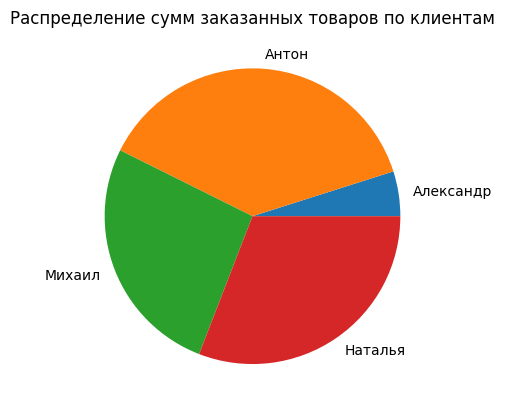

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.pie(np.array(vals)[:,0], labels=np.array(labels)[:,0])
plt.title("Распределение сумм заказанных товаров по клиентам")
plt.show()